In [4]:
%load_ext autoreload
%autoreload 2
INPUT_NAME = "embeddings-epoch100lr.parquet"
OUTPUT_NAME = "20250510-triplet-v2"

In [ ]:
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pathlib import Path
import numpy as np
from animalclef.dataset import split_reid_data, summarize_split
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from tqdm import tqdm
import faiss
from animalclef.metrics import BAKS, BAUS


def get_min_distance_to_neighbor(train_df, k=1):
    @lru_cache(maxsize=16)
    def get_index(individual):
        """get all embeddings that do not belong to an individual. This will form
        the minimum intercluster distance."""
        sub = train_df[train_df.identity != individual]
        # Use the dimension of the embedding vectors
        embedding_dim = len(sub.embeddings.iloc[0])
        index = faiss.IndexFlatL2(embedding_dim)
        index.add(np.stack(sub.embeddings.values))
        return index

    distances = []
    # order the training set by identity so that our lru cache is more efficient
    train_df = train_df.sort_values(by="identity")
    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        # get the index for the individual
        index = get_index(row.identity)
        # search for the nearest neighbor in the training set
        dist, _ = index.search(np.array([row.embeddings]), k)
        # get the average distance to the nearest neighbors
        distances.append(dist.mean())
    return np.array(distances)


def summarize_distances(distances):
    print(f"Min distance: {distances.min()}")
    print(f"Max distance: {distances.max()}")
    print(f"Mean distance: {distances.mean()}")
    print(f"Std distance: {distances.std()}")
    # IQR
    q1 = np.percentile(distances, 25)
    q2 = np.percentile(distances, 50)
    q3 = np.percentile(distances, 75)
    iqr = q3 - q1
    print(f"IQR: {iqr}")
    print(f"Q1: {q1}")
    print(f"Q3: {q3}")
    print(f"Median: {q2}")
    mad = np.median(np.abs(distances - np.median(distances)))
    print(f"MAD: {mad}")


def make_prediction(train_df, other_df, threshold, new_label="new_individual"):
    # Create a FAISS index for efficient nearest neighbor search
    X_train = np.stack(train_df.embeddings.values)
    X_other = np.stack(other_df.embeddings.values)

    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)

    dist, idx = index.search(X_other, 1)
    predictions = train_df.iloc[idx.flatten()]["identity"].values
    # if the distance is above a threshold, it's unknown
    for i, v in enumerate(dist.flatten()):
        if v > threshold:
            predictions[i] = new_label
    return predictions


def search_threshold(train_df, other_df, thresholds):
    identity_other_only = sorted(
        set(other_df.identity.unique()) - set(train_df.identity.unique())
    )

    scores = []
    for threshold in tqdm(thresholds):
        predictions = make_prediction(train_df, other_df, threshold)
        baks = BAKS(other_df["identity"].values, predictions, identity_other_only)
        baus = BAUS(
            other_df["identity"].values,
            predictions,
            identity_other_only,
            "new_individual",
        )
        # geometric average
        score = np.sqrt(baks * baus)
        scores.append(
            {
                "threshold": threshold,
                "baks": baks,
                "baus": baus,
                "score": score,
            }
        )
    return pd.DataFrame(scores)


def plot_threshold_score(df, col="threshold"):
    best_score = df["score"].max()
    best_row = df.iloc[df["score"].idxmax()]
    best_threshold = best_row[col]
    display(best_row.to_dict())

    # plot baus and baks
    plt.plot(
        df[col],
        df["baks"],
        label=f"BAKS (best {df['baks'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["baus"],
        label=f"BAUS (best {df['baus'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["score"],
        label=f"score (best {best_score:.2f})",
    )
    # line at the best threshold
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"best threshold: {best_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Geometric mean of BAKS and BAUS")
    plt.title("Threshold vs Geometric mean of BAKS and BAUS")
    plt.legend()
    plt.show()


def experiment_threshold(train_df, val_df):
    # get stats on the distances
    distances = get_min_distance_to_neighbor(train_df)
    summarize_distances(distances)

    initial_threshold = np.median(distances)
    mad = np.median(np.abs(distances - initial_threshold))
    k = np.linspace(-3, 3, 100)
    mad_threshold_df = search_threshold(
        train_df, val_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
    )
    # add k as a column
    mad_threshold_df["k"] = k
    # display(mad_threshold_df)
    plot_threshold_score(mad_threshold_df, col="k")
    return mad_threshold_df

In [34]:
spark = get_spark(cores=4, memory="2g")

root = Path.home() / "scratch/animalclef"
metadata = spark.read.csv(f"{root}/raw/metadata.csv", header=True, inferSchema=True)
embeddings = spark.read.parquet(f"{root}/processed/{INPUT_NAME}")
embeddings = embeddings.select("image_id", "embeddings")
df = metadata.join(embeddings, on="image_id", how="inner").select(
    "image_id",
    "identity",
    "dataset",
    "embeddings",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
pdf = df.toPandas()

# do the test split
cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
display(summarize_split(train_df, val_df, test_df))

25/05/10 23:34:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- identity_count: long (nullable = false)



,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3690,3690,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2986,0,2986,0,0.0,100.0,0.0,404,54
2,Test,620,5859,0,0,5859,0.0,0.0,100.0,404,216


  4%|▍         | 148/3690 [00:00<00:02, 1282.36it/s]

100%|██████████| 3690/3690 [00:07<00:00, 510.47it/s] 


Min distance: 0.19758453965187073
Max distance: 143.18260192871094
Mean distance: 10.414093971252441
Std distance: 15.568704605102539
IQR: 10.832237243652344
Q1: 2.0241549015045166
Q3: 12.856391906738281
Median: 3.3068432807922363
MAD: 1.750564455986023


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


,threshold,baks,baus,score,k
0,-1.944850,0.000000,1.000000,0.000000,-3.000000
1,-1.838755,0.000000,1.000000,0.000000,-2.939394
2,-1.732660,0.000000,1.000000,0.000000,-2.878788
3,-1.626566,0.000000,1.000000,0.000000,-2.818182
4,-1.520471,0.000000,1.000000,0.000000,-2.757576
...,...,...,...,...,...
95,8.134157,0.144991,0.333851,0.220012,2.757576
96,8.240252,0.145816,0.330148,0.219410,2.818182
97,8.346347,0.146435,0.321461,0.216963,2.878788
98,8.452442,0.146435,0.320916,0.216779,2.939394


{'threshold': 5.057407736778259,
 'baks': 0.12070460085596331,
 'baus': 0.5021666543591975,
 'score': 0.2461987521853054,
 'k': 1.0}

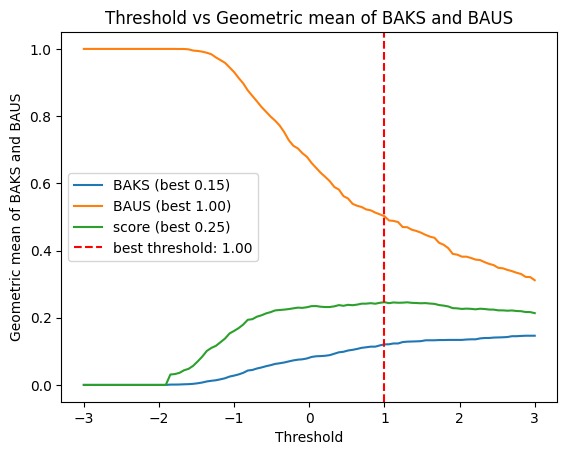

In [39]:
mad_threshold_df = experiment_threshold(train_df, val_df)

  0%|          | 0/6676 [00:00<?, ?it/s]

100%|██████████| 6676/6676 [00:14<00:00, 448.28it/s] 


Min distance: 0.04037586972117424
Max distance: 143.579833984375
Mean distance: 9.436084747314453
Std distance: 14.247387886047363
IQR: 10.080924987792969
Q1: 1.7611572742462158
Q3: 11.842082023620605
Median: 2.9406661987304688
MAD: 1.6253544092178345


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


,threshold,baks,baus,score,k
0,-1.935397,0.000000,1.000000,0.000000,-3.000000
1,-1.836891,0.000000,1.000000,0.000000,-2.939394
2,-1.738384,0.000000,1.000000,0.000000,-2.878788
3,-1.639878,0.000000,1.000000,0.000000,-2.818182
4,-1.541372,0.000000,1.000000,0.000000,-2.757576
...,...,...,...,...,...
95,7.422704,0.149382,0.388100,0.240780,2.757576
96,7.521210,0.149382,0.383860,0.239461,2.818182
97,7.619717,0.149382,0.381244,0.238644,2.878788
98,7.718223,0.153094,0.375670,0.239819,2.939394


{'threshold': 3.8764763131286157,
 'baks': 0.11969094615015999,
 'baus': 0.5552509787427563,
 'score': 0.25779549064427576,
 'k': 0.5757575757575757}

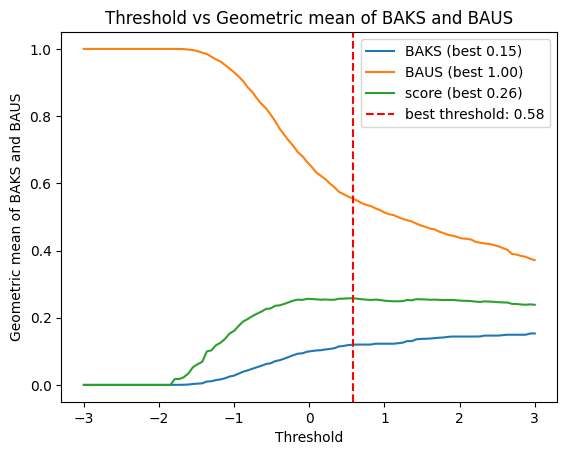

In [40]:
# retune on the test set to get a new best threshold and see if
# this improves the score
mad_threshold_df = experiment_threshold(pd.concat([train_df, val_df]), test_df)

Looks like the score increases if we include more items in the training dataset. This intuitively makes sense because we have more distances to look at.

# final prediction

In [41]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull()]
unknown_df = pdf[pdf.identity.isnull()]

distances = get_min_distance_to_neighbor(known_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": initial_threshold + (mad * best_k),
    }
)

predictions = make_prediction(known_df, unknown_df, initial_threshold + (mad * best_k))
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)

# save this result
unknown_df["identity"] = predictions
output_path = Path.home() / f"shared/animalclef/data/predictions/{OUTPUT_NAME}.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

  0%|          | 0/13074 [00:00<?, ?it/s]

100%|██████████| 13074/13074 [01:08<00:00, 192.06it/s]


{'initial_threshold': np.float32(2.7059646),
 'mad': np.float32(1.6342894),
 'best_k': np.float64(0.5757575757575757),
 'threshold': np.float64(3.646919059030937)}

{'unknown': 1682, 'known': 453, 'total': 2135}

/tmp/ipykernel_433671/2550627590.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


In [42]:
! kaggle competitions submit -c animal-clef-2025 -f {output_path} -m "{OUTPUT_NAME}"

100%|██████████████████████████████████████| 44.6k/44.6k [00:00<00:00, 68.9kB/s]
Successfully submitted to AnimalCLEF25 @ CVPR-FGVC & LifeCLEF